# Extended SONIC model - validation of custom connection scheme

## Rationale

### Objective
Create a custom implementation of the *NEURON **connect*** function to connect 2 sections together that:
- Allows to specify any reference voltage variable to compute axial currents
- Works on a simple multi-compartmental model with multiple nodes connected in series (no branching)
- Yields accurate results
- Does not significantly hinder numerical integration

### Theory of axial conduction
Let's consider the properties of a cylindrical section of diameter $d$, length $L$ and axial resistivity $R_a$ (in $\Omega \cdot cm$):

In [2]:
from IPython.display import Image
Image(url= "axial_resistance.png", width=300)

- Axial (i.e. cross-sectional) surface area: $A_x = \pi d^2 / 4$
- Longitudinal (i.e. membrane) surface area: $A_m = \pi d L$
- Axial resistance: $R = \frac{R_a L}{A_x}$  (in $\Omega$)

The axial current flowing between the centers of two adjacent sections of resistances $R_1, R_2$ (in $\Omega$) and voltages $V_1, V_2$ (in $mV$), respectively, is: 
$I_{ax, 1-2} = \frac{V_2 - V_1}{R_1 / 2 + R_2 / 2}$ (in mA)

Thus, for a section **k** connected in series with **k-1** and **k+1** compartments, the total axial current flowing in the section is: 
$I_{ax, k} = 2 \big(\frac{V_k - V_{k-1}}{R_k + R_{k-1}} + \frac{V_k - V_{k+1}}{R_k + R_{k+1}}\big)$ (in mA)

For a simple model consisting of multiple connected nodes with equal diameter $d$, length $L$ and cytoplasmic resistivity $R_a$, we have: 
$I_{ax, k} = \frac{(2 V_k - V_{k-1} - V_{k+1})}{R} \propto \frac{A_x}{R_a L} = \frac{\pi d^2}{4 R_a L}$

Thus axial current is proportional to $d^2$, $1/R_a$ and $1/L$.

### Problem
If we connect adjacent section using the standard *NEURON* **connect** function, the contribution of axial currents to the evolution of distributed membrane potentials is computed implicitly using $v$ as the reference voltage variable.

### Solution
Implement axial current as a distributed membrane mechanism that computes a current density similarly to other membrane currents: 
$i_{ax, k} = \frac{I_{ax, k}}{A_m}$  (in $mA/cm^2$)
- axial resistances of previous, current and next sections are provided to the mechanism as static RANGE parameters
- membrane potentials of previous, current and next sections are provided to the mechanism as POINTER variables, pointing to the reference voltage variable of choice, in order to be dynamically updated throughout the simulation

For the same simple model presented above, axial current density would be computed as 
$i_{ax, k} = \frac{I_{ax, k}}{A_m} \propto \frac{d}{4 R_a L^2}$, 
and is thus proportional to $d$, $1/R_a$ and $1/L^2$.

### Implementation
To implement our custom connection scheme, a ***SeriesConnector*** object is defined.

It contains the following attributes:
- ***mechname***: the name of the custom density mechanism that computes axial current
- ***vref***: the name of the reference voltage variable to compute axial currents

And the following methods:
- ***attach***: inserts a specific axial current density mechanism into a section and set appropriate axial conduction parameters
- ***connect***: connects two adjacent sections in series, by setting appropriate PARAMETER and POINTER variables to create a bi-directional link


## Validation
Let's validate our custom implementation against the classic ***connect*** function, by comparing the generation and propagation of action potentials upon electrical stimulation.

### Imports
Let's import the necessary packages and modules

In [2]:
import sys
import time
import logging
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.utils import logger, si_format
from PySONIC.neurons import CorticalRS
from connectors import SeriesConnector
from sonic1D import compareEStim

logger.setLevel(logging.DEBUG)

### Parameters
Let's set some default model and stimulation parameters.

By default, we will use an adaptive time step (CVODE) method, as we will see later that this method is far better than the fixed time step method to ensure convergence (sometimes at the expense of computation speed).

In [3]:
# Model parameters
neuron = CorticalRS()
nnodes = 3
Ra = 1e2  # default order of magnitude found in litterature (Ohm.cm)
d = 1e-6  # order of magnitude of axon node diameter (m)
L = 1e-5  # between order of magnitude of axon node length (1 um) and internode length (100um - 1 mm)

# Stimulation parameters
Astim = 30.0  # mA/m2
tstim = 150e-3  # s
toffset = 100e-3  # s
PRF = 100.  # Hz
DC = 1.

### SeriesConnector object
Let's build a ***SeriesConnector*** object based on the *Iax* density mechanism and using the NEURON's default variable ***v*** as its reference voltage variable:

In [4]:
# SeriesConnector object to connect sections in series through custom implementation
connector = SeriesConnector(vref='v', rmin=None)
print(connector)

Series connector object: Iax density mechanism, reference voltage variable = "v"


## Default conditions

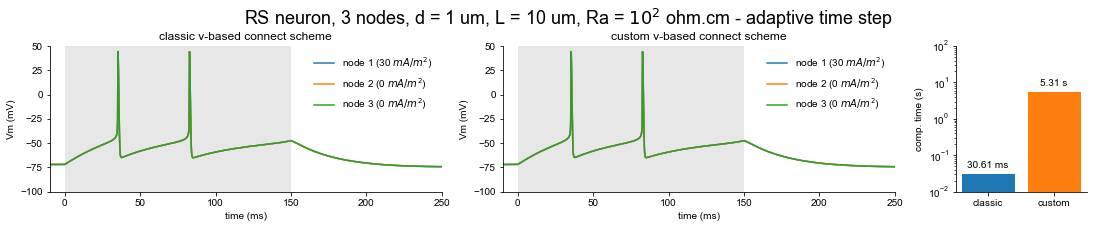

In [5]:
fig = compareEStim(neuron, nnodes, d, L, Ra, connector, Astim, tstim, toffset, PRF, DC)

Expectedly, in these default conditions, the small node length limits axial axial resistance, therefore axial currents allow total "synchronization" of nodes, and distributed membrane potential profiles are identical.

Both solutions look identical. However, the custom implementation yields **significantly slower computation times than the classic one (more than 2 orders of magnitude slower !!!)**.

### Restricting axial conduction

It seems that our custom connection scheme generates axial current densities of strong magnitude, thereby increasing the system stiffness and forcing the CVODE solver to drastically reduce time step size to ensure convergence.

However, it is not necessary to increase the system stiffness to this extent, as higher axial resistance densities (i.e. axial currents of lower magnitude) still allow complete synchronization of the 2 nodes:

R*Am = 1.0e+02 Ohm.cm2
R*Am = 2.0e+02 Ohm.cm2
R*Am = 5.0e+02 Ohm.cm2
R*Am = 1.0e+03 Ohm.cm2


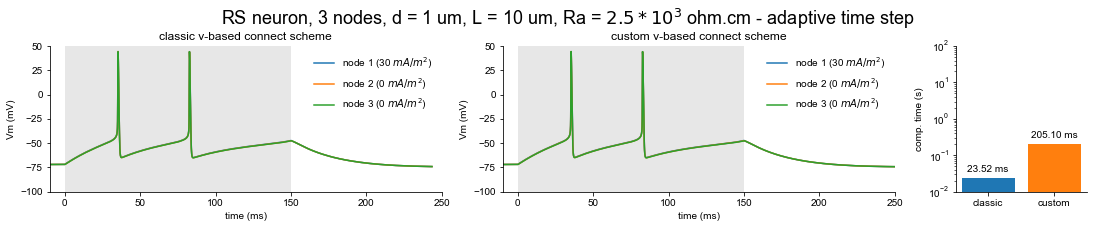

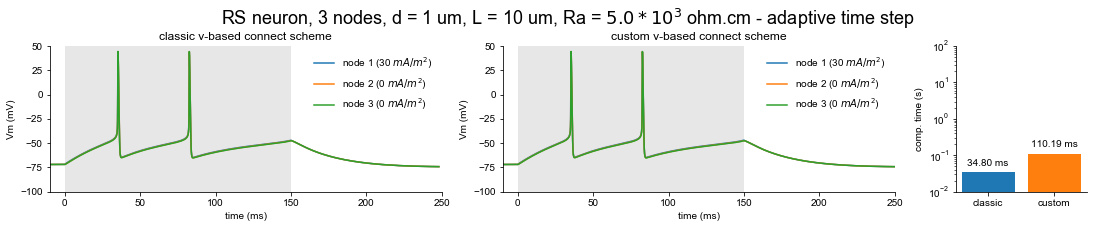

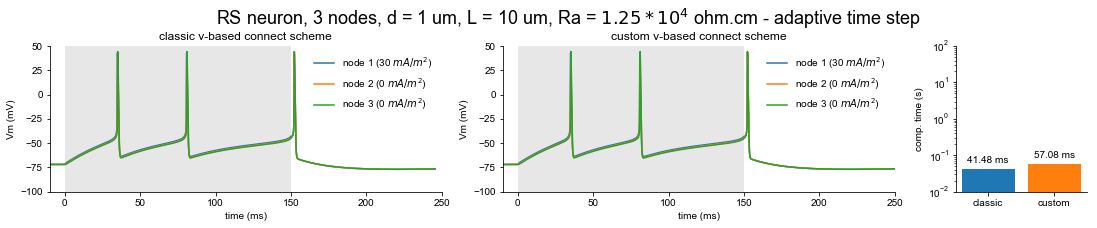

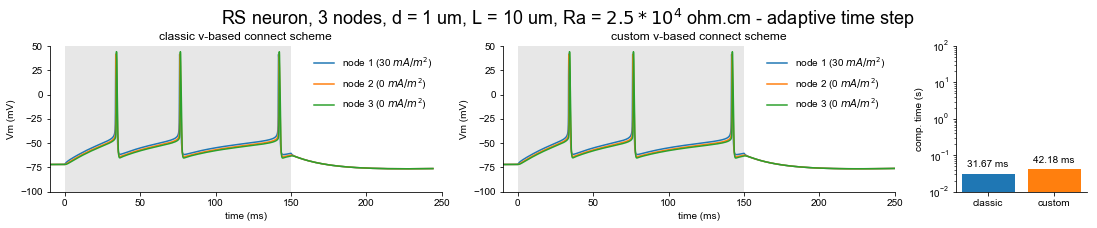

In [6]:
for Ra_range in np.array([1, 2, 5, 10]) * 1e4 / 4:
    Ax = np.pi * (d * 1e2)**2 / 4  # cm2
    Am = np.pi * (d * 1e2) * (L * 1e2)  # cm2
    R = Ra_range * (L * 1e2) / Ax  # Ohm
    print('R*Am = {:.1e} Ohm.cm2'.format(R * Am))
    fig = compareEStim(neuron, nnodes, d, L, Ra_range, connector, Astim, tstim, toffset, PRF, DC)

In fact, from these results it seems that node desynchronization only starts occurring as $R \cdot A_m$ goes above $10^2\ \Omega \cdot cm^2$ (more precisely, between $2 \cdot 10^2$ and $5 \cdot 10^2\ \Omega \cdot cm^2$).

Hence, let's try to limit the magnitude of axial current density $i_{ax, k} = \frac{\Delta V}{R \cdot A_m}$ by setting a lower bound for $R \cdot A_m$ to the less stringent (hence supposedly "safer") value of $2 \cdot 10^2$ $\Omega \cdot cm^2$:

In [7]:
connector.rmin = 2e2  # Set minimal "resistance density" in custom axial current mechanism 
print(connector)

Series connector object: Iax density mechanism, reference voltage variable = "v", minimal resistance density = 2.00e+02 Ohm.cm2


Let's check the consequences of that restriction for the default conditions tested above:

R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


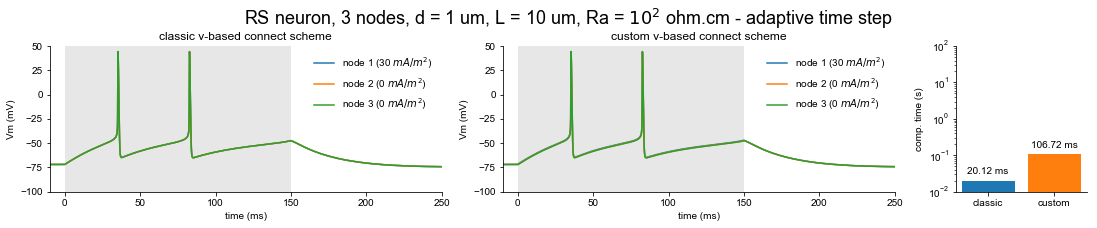

In [8]:
fig = compareEStim(neuron, nnodes, d, L, Ra, connector, Astim, tstim, toffset, PRF, DC)

The axial resistance density here is increased by 2 orders of magnitude, which effectively reduces the amplitude of axial current densities and the system's stiffness. As a result: 
- computation time is drastically reduced (but stays higher than with the traditional connection scheme)
- the solution is still accurate

## Robustness to changes in parameters

Let's now test the robustness of our implementation to various changes in model and stimulation parameters.

In [9]:
logger.setLevel(logging.INFO)

### Node diameter

d = 10 pm: R*Am = 4.0e+05 Ohm.cm2 -> not bounded
d = 1 nm: R*Am = 4.0e+03 Ohm.cm2 -> not bounded
d = 100 nm: R*Am = 4.0e+01 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
d = 10 um: R*Am = 4.0e-01 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


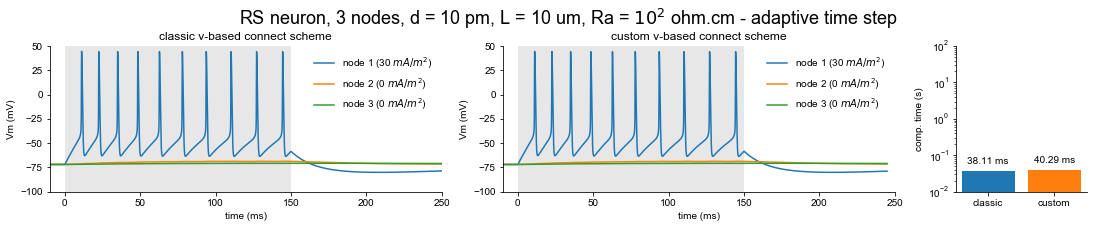

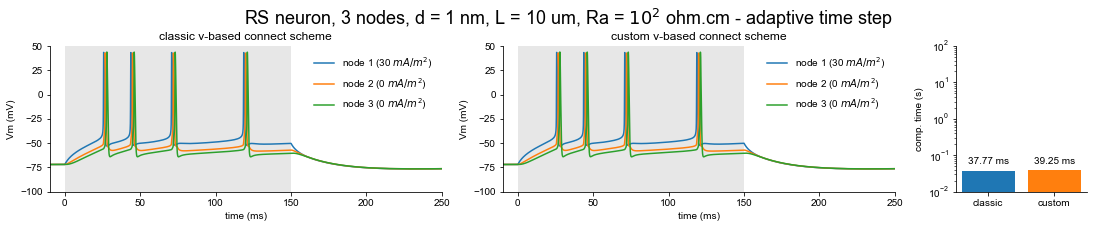

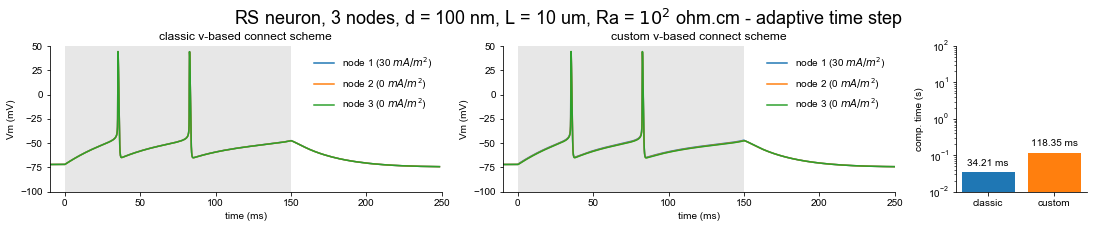

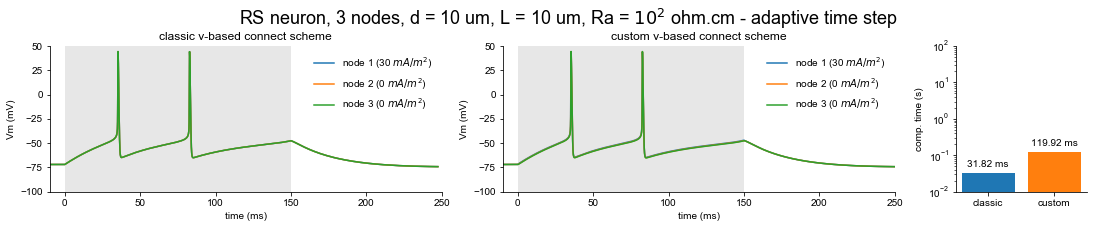

In [10]:
for d_range in np.logspace(-11, -5, 4):
    sys.stdout.write('d = {}m: '.format(si_format(d_range, space=' ')))
    fig = compareEStim(neuron, nnodes, d_range, L, Ra, connector, Astim, tstim, toffset, PRF, DC)

Our implementation seems robust to change in $d$, even for values *way below* the realistic range of node diameters:
- For very small node diameters, the huge axial resistance limits axial currents, which prevents action potentials from spreading to neighboring nodes.
- As node diameter increases, reduced axial resistance allows action potentials to spread to neighboring nodes, but with an intrinsic delay that increases with distance.
- For large node diameters, very small axial resistance allows prefect "synchronization" between all nodes.

### Node length

L = 10 um: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
L = 46 um: R*Am = 8.6e+01 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
L = 215 um: R*Am = 1.9e+03 Ohm.cm2 -> not bounded
L = 1 mm: R*Am = 4.0e+04 Ohm.cm2 -> not bounded


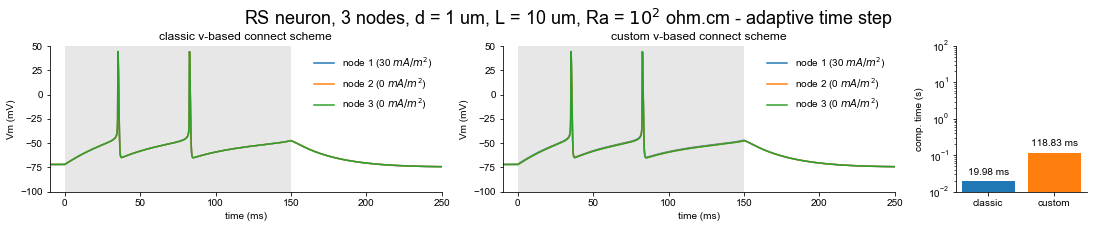

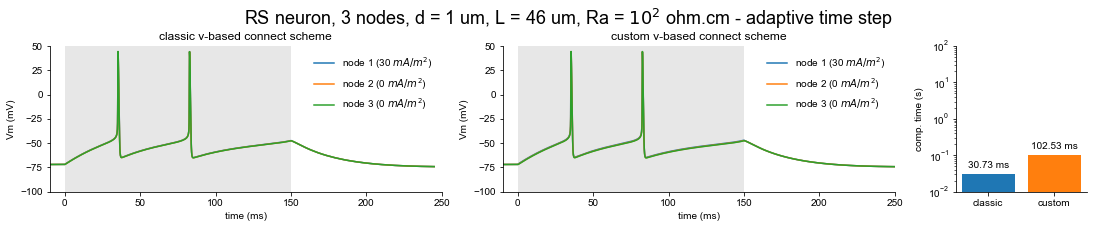

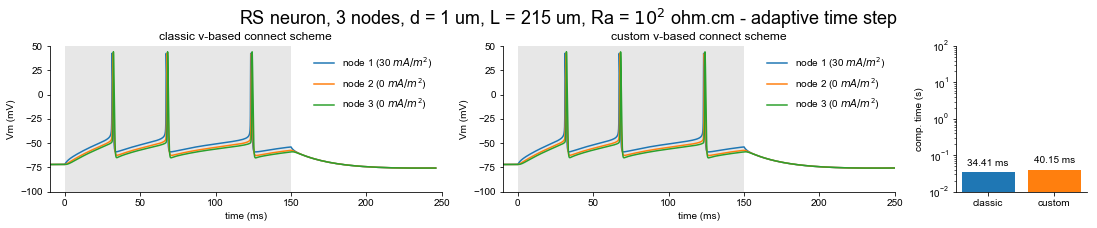

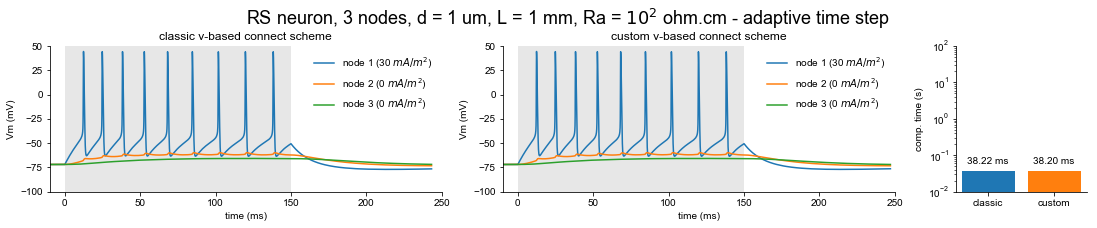

In [11]:
for L_range in np.logspace(-5, -3, 4):
    sys.stdout.write('L = {}m: '.format(si_format(L_range, space=' ')))
    fig = compareEStim(neuron, nnodes, d, L_range, Ra, connector, Astim, tstim, toffset, PRF, DC)

Our implementation seems also robust to changes in $L$.

The effect is exactly the opposite as for $d$: increasing node length augments axial resistance and thereby reduces cross-node synchronization.

Moreover, we notice that the **lower-bound restriction of axial resistance density is applied for short node lengths** ($L \lt 100 \mu m$) that are **within the range of possibilities for the length of a Ranvier node in a myelinated axon or that of an unmyelinated axon section.**

### Cytoplasmic resistivity

Ra = 1.00e+01 Ohm.cm2: R*Am = 4.0e-01 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
Ra = 1.00e+03 Ohm.cm2: R*Am = 4.0e+01 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
Ra = 1.00e+05 Ohm.cm2: R*Am = 4.0e+03 Ohm.cm2 -> not bounded
Ra = 1.00e+07 Ohm.cm2: R*Am = 4.0e+05 Ohm.cm2 -> not bounded


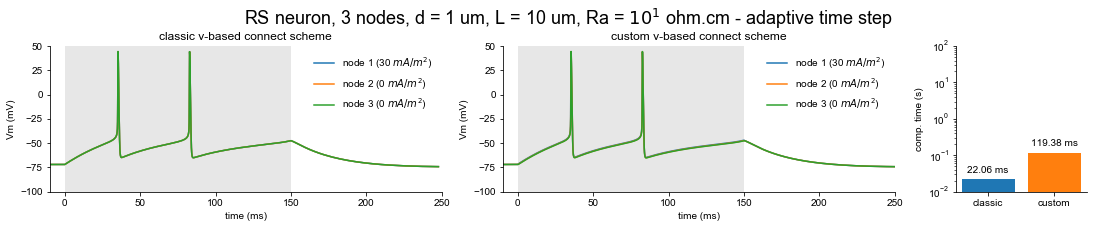

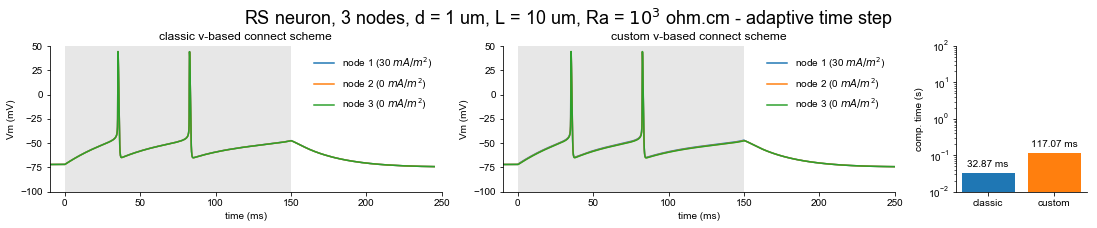

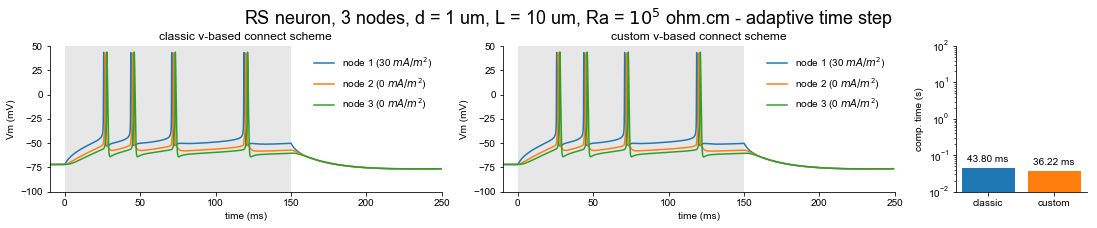

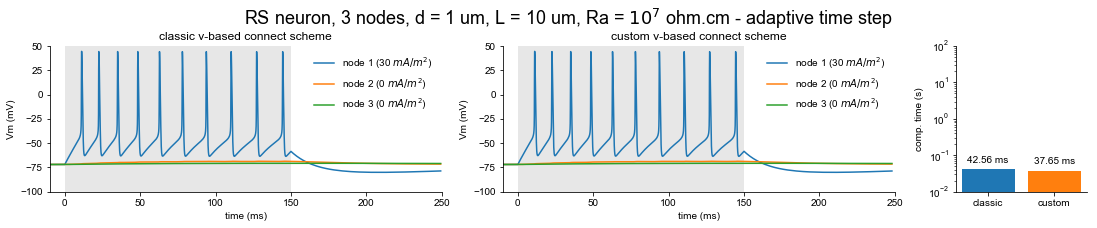

In [12]:
for Ra_range in np.logspace(1, 7, 4):
    sys.stdout.write('Ra = {:.2e} Ohm.cm2: '.format(Ra_range))
    fig = compareEStim(neuron, nnodes, d, L, Ra_range, connector, Astim, tstim, toffset, PRF, DC)

Our implementation seems also robust to changes in $R_a$, even for values *way beyond* the realistic range of resistivity.

The effect is similar to that of $L$: increasing cytoplasmic resistivity augments axial resistance and thereby reduces cross-node synchronization.

### Number of nodes

2 nodes: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
3 nodes: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
4 nodes: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


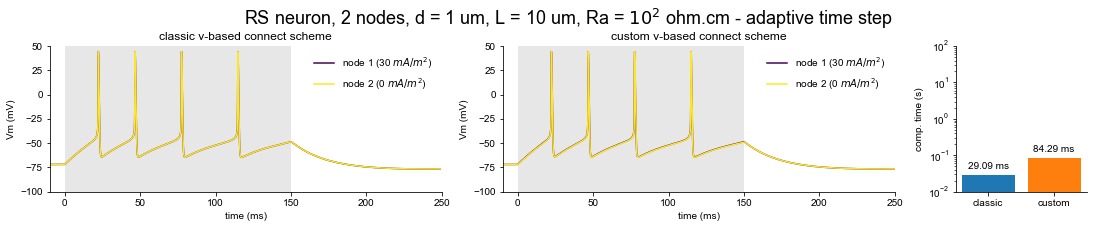

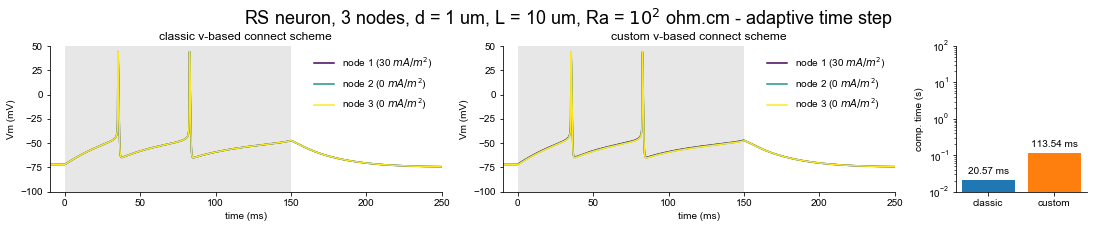

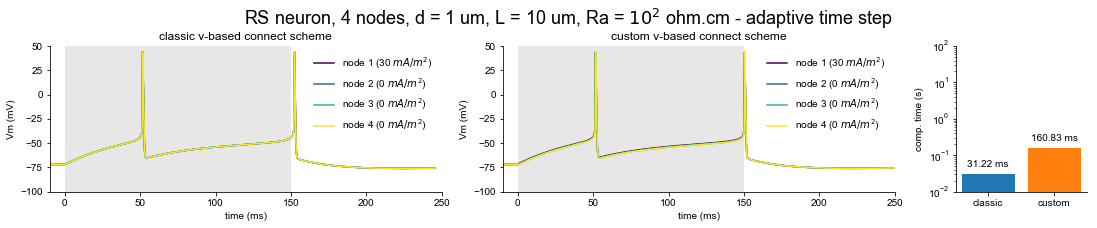

In [14]:
for nnodes_range in range(2, 5):
    sys.stdout.write('{} nodes: '.format(nnodes_range))
    fig = compareEStim(neuron, nnodes_range, d, L, Ra, connector, Astim, tstim, toffset, PRF, DC, cmode='seq')

Our implementation is also robust to changes in $n_{nodes}$.

Increasing the number of nodes creates a higher axial driving force at the stimulated node: axial currents spread more intensely towards neighboring nodes, thereby limiting the depolarization of the stimulated node. As a result, less action potentials are fired, but they're all conducted through all nodes.

In terms of computation times, it is interesting to note that with the classic connection scheme, integration is more efficient as the number of nodes increases, whereas the opposite trend is observed with our custom scheme.

### Stimulus amplitude

A = 20 mA/m2: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
A = 30 mA/m2: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
A = 40 mA/m2: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


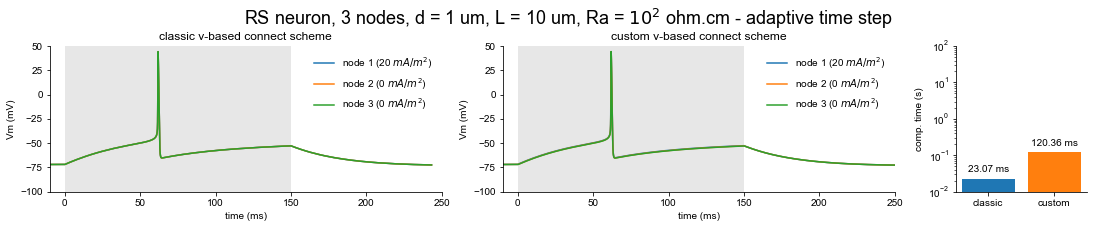

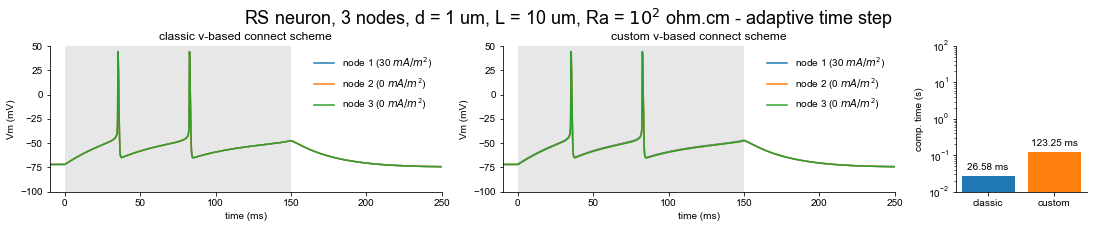

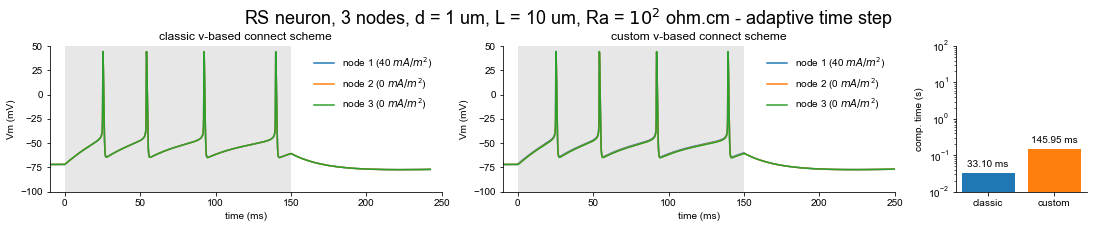

In [15]:
for Astim_range in np.linspace(20, 40, 3):
    sys.stdout.write('A = {:.0f} mA/m2: '.format(Astim_range))
    fig = compareEStim(neuron, nnodes, d, L, Ra, connector, Astim_range, tstim, toffset, PRF, DC)

Our implementation is robust to changes in $A_{stim}$.

Expectedly, increasing the magnitude of depolarizing current accelerates membrane depolarization, hence the neuron fires more action potentials.

### Stimulus duty cycle

DC = 50%: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
DC = 70%: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
DC = 90%: R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2


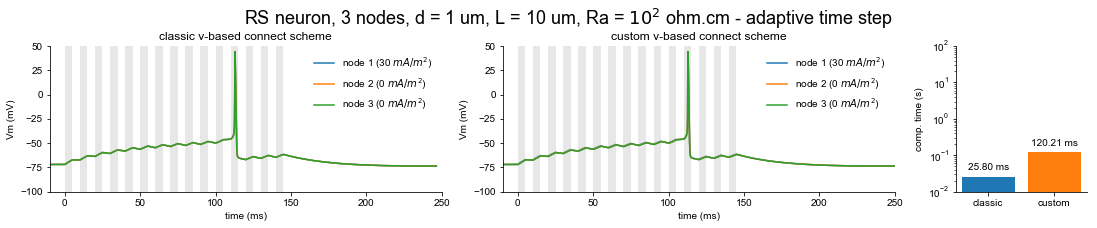

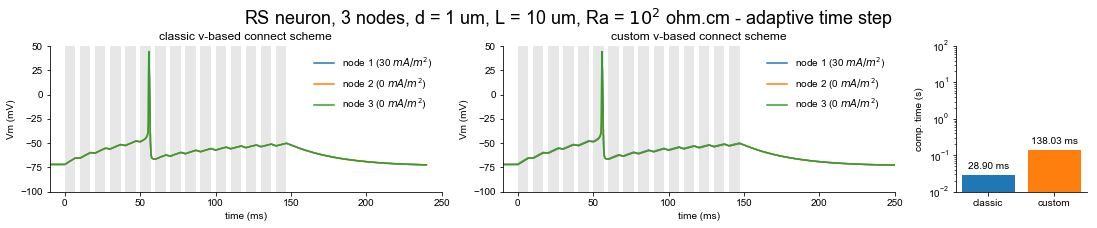

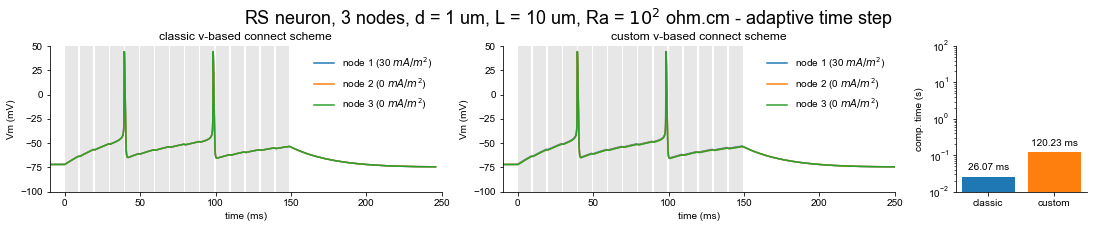

In [16]:
for DC_range in np.linspace(0.5, 0.9, 3):
    sys.stdout.write('DC = {:.0f}%: '.format(DC_range * 1e2))
    fig = compareEStim(neuron, nnodes, d, L, Ra, connector, Astim, tstim, toffset, PRF, DC_range)

Our implementation is robust to changes in $DC$.

Expectedly, increasing the stimulus duty cycle accelerates membrane depolarization, hence the neuron fires more action potentials.

## Computational efficiency

So far, we have used an **adaptive time step (CVODE)** method with its default absolute error tolerance value $a_{tol} = 10^{-3}$. We've seen that **this method ensures convergence, but its efficiency depends on inversely proportional to the magnitude of axial current densities**: 
- **Without restricting axial resistance density**, resolution times reach **several seconds** in typical conditions, and can reach up to a **few minutes** for conditions that facilitate large axial condition (i.e. large diameter, small node length, small cytoplasmic resistivity). 
- **With lower bound restriction on axial resistance density**, resolution times are bounded to a **maximum of ca. 150 ms** (for the 2 nodes configuration).

While this is a definite improvement, resolution times are still significantly longer than that obtained with the classic method. Moreover, it seems that **the classic connection scheme is more efficient to integrate systems with large axial currents, whereas our custom implementation becomes less efficient when axial conduction increases**.

## Optimization of integration method

Let's compare the performances of the fixed and adaptive time step integration methods, in order to infer on the most suited configuration.

### Fixed time step

fixed time step integration (dt = 0.1 ms)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
fixed time step integration (dt = 0.1 ms)
fixed time step integration (dt = 0.21544346900318845 ms)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
fixed time step integration (dt = 0.21544346900318845 ms)
fixed time step integration (dt = 0.46415888336127775 ms)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
fixed time step integration (dt = 0.46415888336127775 ms)
fixed time step integration (dt = 1.0 ms)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
fixed time step integration (dt = 1.0 ms)


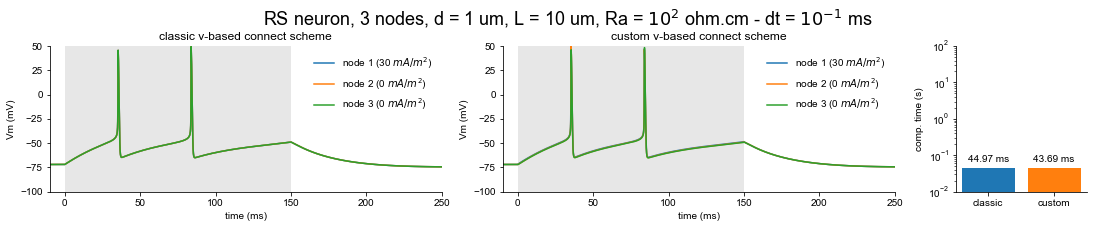

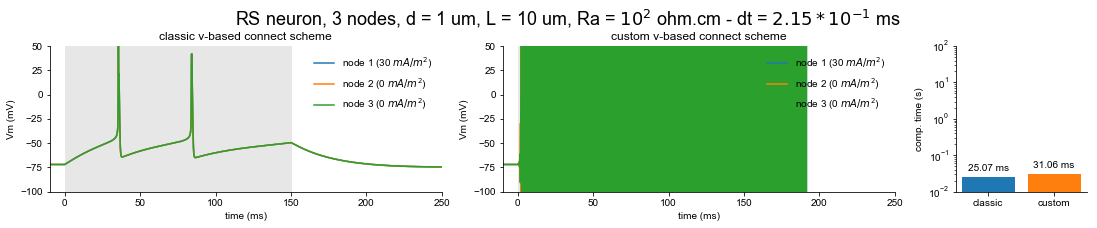

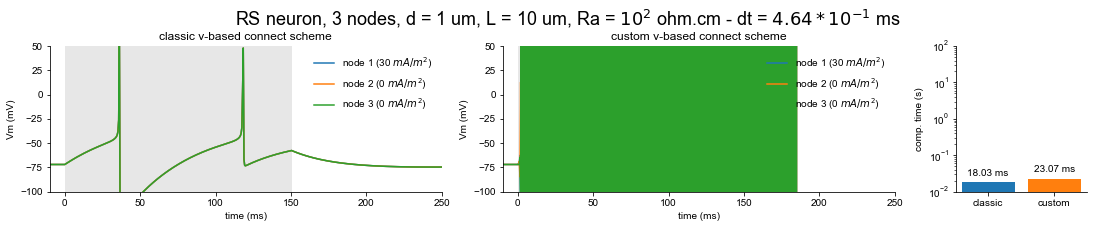

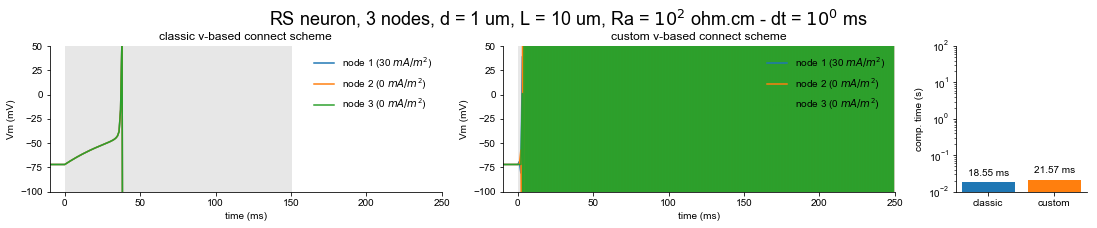

In [17]:
for dt in np.logspace(-4, -3, 4):
    # sys.stdout.write('dt = {:.0e} ms: '.format(dt * 1e3))
    fig = compareEStim(neuron, nnodes, d, L, Ra, connector, Astim, tstim, toffset, PRF, DC, dt=dt)

Interestingly, the **fixed time step method yields similar computation times with the classic and custom connection schemes**: in both cases, $t_{comp}$ decreases as $dt$ increases. 

Both schemes converge with a time step up to $dt = 10^{-1}\ ms$, above which they start diverging, but with very different sensitivities to time step:
- With the classic connection scheme, divergence increases very progressively between $10^{-1}$ and $10^0\ ms$.
- With the custom connection scheme, divergence grows drastically when $dt$ goes above the convergence threshold.

Hence **the classic connection scheme is less sensitive to time step**. 

Nonetheless, it looks like a time step of $dt = 10^{-1}\ ms$ is a good trade-off between speed and accuracy.

### Variable time step

adaptive time step integration (atol = 0.1)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
adaptive time step integration (atol = 0.1)
adaptive time step integration (atol = 1.0)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
adaptive time step integration (atol = 1.0)
adaptive time step integration (atol = 10.0)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
adaptive time step integration (atol = 10.0)
adaptive time step integration (atol = 100.0)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
adaptive time step integration (atol = 100.0)


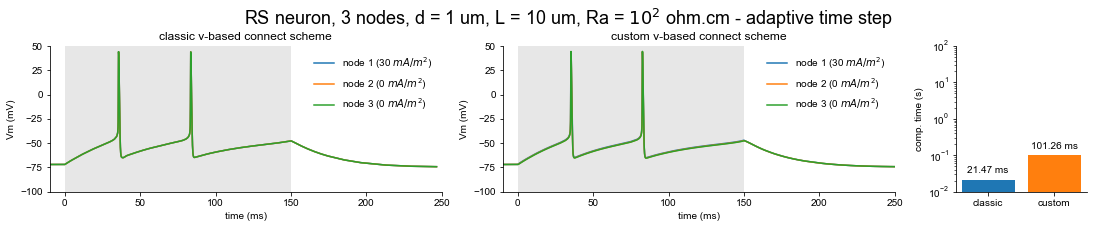

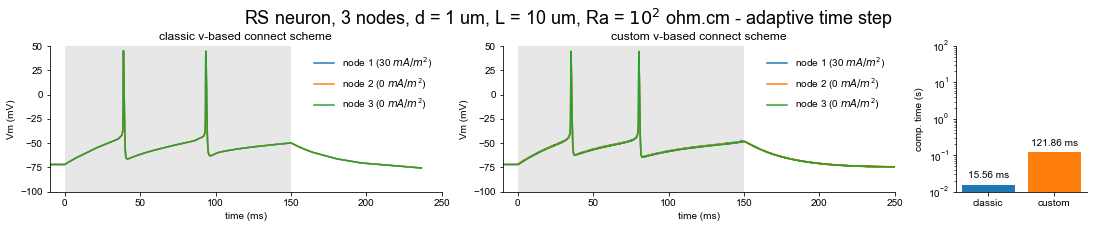

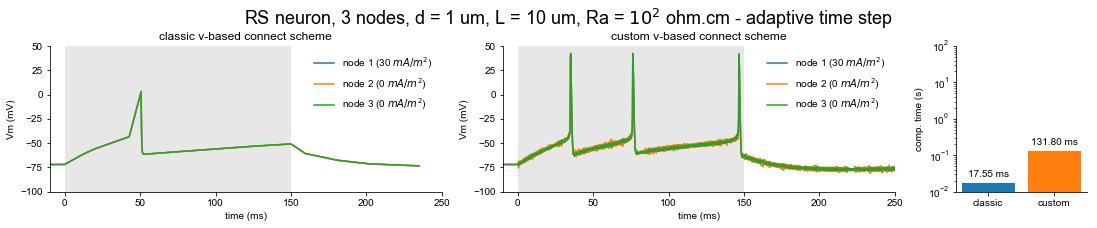

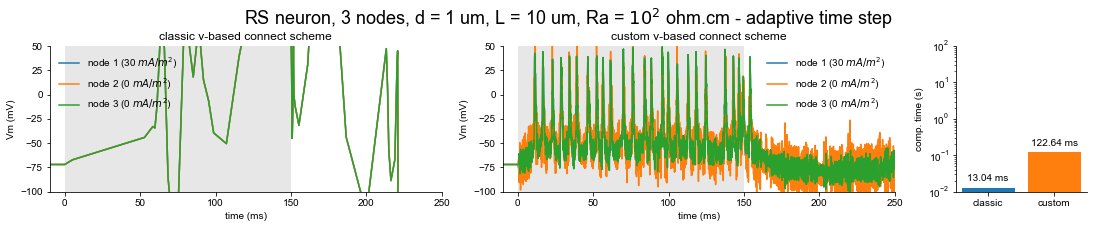

In [18]:
for atol in np.logspace(-1, 2, 4):
    # sys.stdout.write('dt = {:.0e} ms: '.format(dt * 1e3))
    fig = compareEStim(neuron, nnodes, d, L, Ra, connector, Astim, tstim, toffset, PRF, DC, atol=atol)

Expectedly, **the variable time step method yields far longer computation times with our custom connection scheme**. More surprisingly, **with both schemes computation time is more or less constant across a wide range of absolute error tolerance**.

Both schemes converge with an absolute  error tolerance up to $a_{tol} = 10^{0}$, above which they start diverging with remarkably different patterns:
- With the **classic connection scheme, spike shapes become unrealistic very quickly, however both nodes stay "voltage-locked"**.
- With the **custom connection scheme, spike shapes are less sensitivities to $a_{tol}$, but node synchronization is more quickly altered**.

Since augmenting error tolerance does not seem to yield faster computations, it does not make sense to loosen the default value of $a_{tol} = 10^{-3}$.

### Variable vs. Fixed time step

Let's compare computational efficiency and accuracy of both methods.

adaptive time step integration (atol = 0.001)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
adaptive time step integration (atol = 0.001)
fixed time step integration (dt = 0.1 ms)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
fixed time step integration (dt = 0.1 ms)


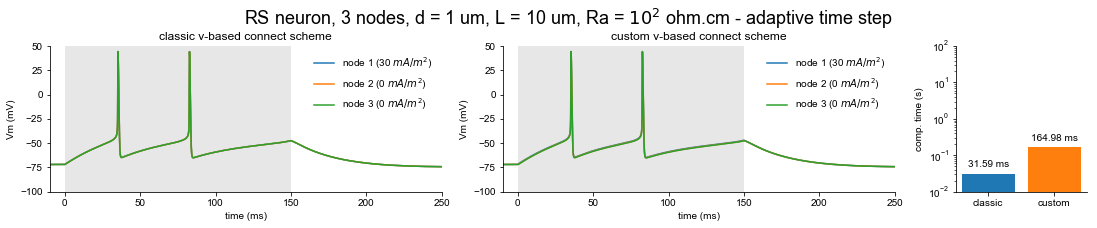

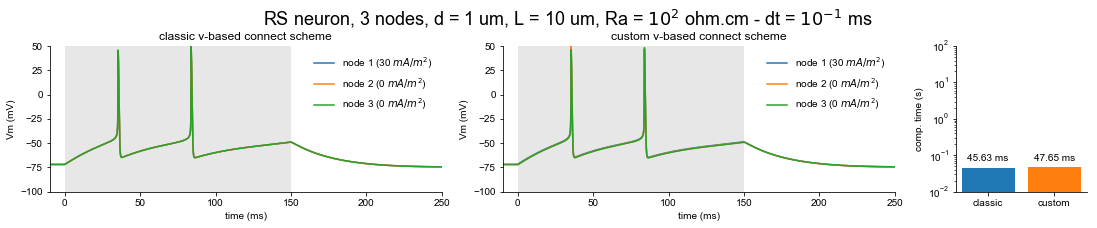

In [19]:
fig = compareEStim(neuron, nnodes, d, L, Ra, connector, Astim, tstim, toffset, PRF, DC, atol=1e-3)
fig = compareEStim(neuron, nnodes, d, L, Ra, connector, Astim, tstim, toffset, PRF, DC, dt=1e-4)

While the adaptive time step method is slightly faster using the classic connection scheme, the **fixed time step method is significantly faster with the custom connection scheme**, at least in these conditions. Hence, it seems more suited in the present configuration.

Let's now test both method with a different connection scheme based on $V_{m,eff}$:

adaptive time step integration (atol = 0.001)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
adaptive time step integration (atol = 0.001)
fixed time step integration (dt = 0.1 ms)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
fixed time step integration (dt = 0.1 ms)
fixed time step integration (dt = 0.01 ms)
R*Am = 4.0e+00 Ohm.cm2 -> bounded to 2.0e+02 Ohm.cm2
fixed time step integration (dt = 0.01 ms)


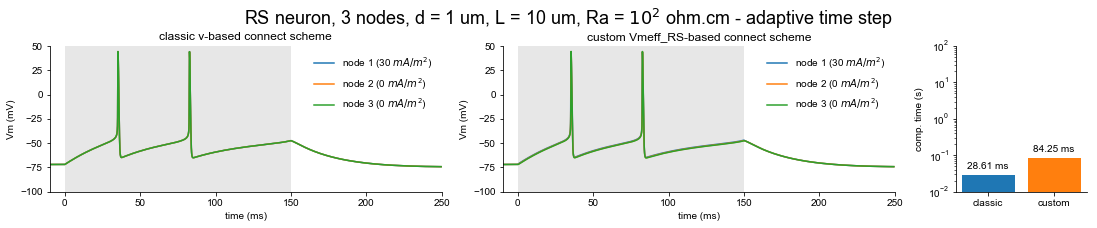

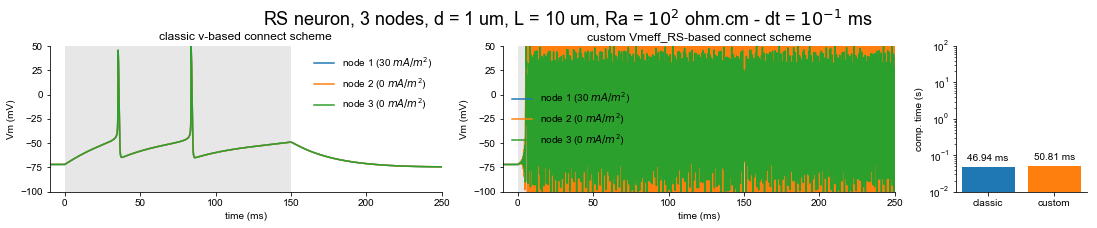

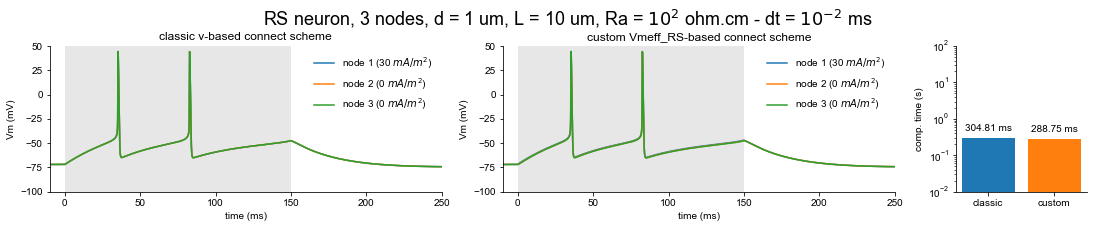

In [20]:
Vmeff_connector = SeriesConnector(vref='Vmeff_{}'.format(neuron.name))
fig = compareEStim(neuron, nnodes, d, L, Ra, Vmeff_connector, Astim, tstim, toffset, PRF, DC, atol=1e-3)
fig = compareEStim(neuron, nnodes, d, L, Ra, Vmeff_connector, Astim, tstim, toffset, PRF, DC, dt=1e-4)
fig = compareEStim(neuron, nnodes, d, L, Ra, Vmeff_connector, Astim, tstim, toffset, PRF, DC, dt=1e-5)

- The adaptive method still allows convergence and does not increase computation time with $a_{tol} = 10^{-3}$
- For the fixed method, time step must be decreased to $dt = 10^{-2}\ ms$ to ensure convergence, at which point it becomes significantly less efficient than the adaptive method (with both connection schemes)

Hence, **the fixed time step method is actually far less robust than the adaptive method**.

## Conclusions

- The **custom implementation** of axial currents contribution as a density mechanism is **accurate across all conditions**.
- Simulation results confirm that **cross-node synchronization is proportional to the magnitude of axial currents**.
- Setting an **appropriate lower bound for axial "resistance density" ($R \cdot A_m$)** effectively decreases system stiffness, allowing to **keep computation time below an acceptable range while maintaining results accuracy**. We should stay aware of that transformation though, since it is **applied in some realistic parameter combinations (e.g. small node length)**. 
- The fixed and adaptive time step integration methods behave very differently:

|                                     | Fixed time step              |  Adaptive time step                                     |
|:-----------------------------------:|:----------------------------:|:-------------------------------------------------------:|
| **General convergence criterion**   | conditions-dependent         | $a_{tol} \lt 10^{-3}$                                   |
| **Classic scheme convergence**      | sensitive to time step       | alteration of membrane dynamics first                   |
| **Custom scheme convergence**       | very sensitive to time step  | alteration of axial conduction first                    |
| **General efficiency**              | time-step dependent          | $t_{comp} \lt 150 ms$ (with 2 nodes)                    |
| **Classic scheme efficiency**       | stable (for fixed dt)        | more efficient with large $I_{ax}$                      |
| **Custom scheme efficiency**        | stable (for fixed dt)        | more efficient with small $I_{ax}$                      |
| **Classic vs custom efficiency**    | equivalent                   | depends on ref. voltage variable and $I_{ax}$ magnitude |
 
- Overall, the **adaptive integration method is far more robust** than the fixed time step method, can be used with a **constant meta-parameter value ($a_{tol} \lt 10^{-3}$)**, and **keeps computation times below a certain limit** for given model extent (number of nodes).  
- It would be worth investigating **why the classic connection scheme is globally more efficient** than the custom implementation, but also **why their efficiencies have opposite sensitivities to the magnitude of axial currents**. 
- Our custom connection scheme used together with the adaptive integration method seems accurate and reasonably efficient to be used for acoustic simulations (using this time $V_{m, eff}$ as the reference voltage variable).